# Notebook Contents

- [Imports](#Imports)
- [Data](#Data)
- [Modeling](#Modeling)
    - [4-Seam Fastball](#4-Seam-Fastball)
        - [4-Seam Cluster Label](#Cluster-Labels---4-Seam)
    - [Slider](#Slider)
        - [Slider Cluster Label](#Cluster-Labels---Slider)
    - [Changeup](#Changeup)
        - [Changeup Cluster Label](#Cluster-Labels---Changeup)
    - [Cutter](#Cutter)
        - [Cutter Cluster Label](#Cluster-Labels---Cutter)

# Imports

In [1]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, k_means
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.feature_selection import SelectKBest
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score

import warnings
warnings.filterwarnings('ignore')

# Data

In [2]:
pd.set_option('max_columns', None)

data = pd.read_csv('../data/arsenal-spin.csv')
data.drop(columns = ['Unnamed: 0', 'player_id', 'pitches', 'n_pitches',
                     'diff_measured_inferred_minutes', 'diff_clock_hh', 
                     'diff_measured_inferred', 'hawkeye_measured', 'movement_inferred', 
                     'alan_active_spin_pct', 'diff2', 'diff_clock_mm', 'hawkeye_measured_clock_hh', 
                     'hawkeye_measured_clock_mm', 'hawkeye_measured_clock_hh', 'hawkeye_measured_clock_mm', 
                     'movement_inferred_clock_hh', 'movement_inferred_clock_mm'], inplace = True)
data = data.sort_values(by = ['last_name_x'], ascending = True)

# Binarize pitch types
data['pitch_type'] = data['pitch_type'].map({'FS': 5, 'FC': 4, 'CH': 3, 'SL': 2, 'FF': 1})

data = pd.get_dummies(data, columns = ['pitch_hand'])

# Index by Pitch Name
ff = data.loc[data['pitch_name_y'] == '4-Seam Fastball']
sl = data.loc[data['pitch_name_y'] == 'Slider']
ch = data.loc[data['pitch_name_y'] == 'Changeup']
fc = data.loc[data['pitch_name_y'] == 'Cutter']
fs = data.loc[data['pitch_name_y'] == 'Splitter']

print(data.shape)
data.head()

(869, 31)


,last_name_x,last_name_y,first_name_x,pitch_type,pitch_name_x,pitch_name_y,pitch_usage,release_speed,spin_rate,movement_inches,spin_eff%,active_spin,run_value_per_100,run_value,pa,ba,slg,woba,whiff_percent,k_percent,put_away,est_ba,est_slg,est_woba,hard_hit_percent,hawkeye_measured_clock_label,movement_inferred_clock_label,diff_clock_label,team_name_alt,pitch_hand_L,pitch_hand_R
0,Abreu,Abreu,Bryan,2,Slider,Slider,37.2,88.9,2526,6.2,32,0.324769,1.9,5,63,0.246,0.456,0.338,38.0,28.6,22.5,0.253,0.423,0.332,45.0,7:30,7:30,0H 00M,HOU,0,1
1,Abreu,Abreu,Bryan,1,4-Seamer,4-Seam Fastball,45.0,95.7,2216,18.6,93,0.925214,-0.1,0,66,0.273,0.418,0.379,23.9,12.1,11.4,0.274,0.428,0.367,34.0,1:00,1:00,0H 00M,HOU,0,1
2,Adams,Adams,Austin,2,Slider,Slider,87.1,86.9,2837,10.8,37,0.370953,-0.8,-7,217,0.145,0.208,0.288,35.3,33.2,28.7,0.158,0.256,0.307,23.7,8:15,9:00,-0H 45M,SD,0,1
3,Akin,Akin,Keegan,3,Changeup,Changeup,19.5,81.9,1936,17.4,95,0.953193,2.8,9,100,0.333,0.494,0.405,29.1,16.0,17.6,0.248,0.425,0.334,38.9,10:00,9:45,+0H 15M,BAL,1,0
4,Akin,Akin,Keegan,1,4-Seamer,4-Seam Fastball,57.2,92.0,2337,20.7,97,0.969171,-0.6,-6,231,0.250,0.451,0.331,20.0,22.1,14.2,0.253,0.487,0.353,43.9,10:45,11:00,-0H 15M,BAL,1,0


# Modeling

### Multicolinearity - VIF

In [3]:
features = data.select_dtypes([np.number])
vif_data = pd.DataFrame()
vif_data["feature"] = features.columns

vif_data["VIF"] = [variance_inflation_factor(features.values, i)
                   for i in range(len(features.columns))]

vif_data.sort_values(by = 'VIF').head(11)

,feature,VIF
9,pa,1.330905
1,pitch_usage,1.689636
0,pitch_type,2.182406
19,hard_hit_percent,2.850410
3,spin_rate,3.298621
2,release_speed,3.428532
15,put_away,4.288307
13,whiff_percent,4.553517
8,run_value,5.535584
7,run_value_per_100,7.202815


## 4-Seam Fastball

In [4]:
features_ff = ff.select_dtypes([np.number])
X_ff = features_ff

ss = StandardScaler()
X_ff_scaled = ss.fit_transform(X_ff)
X_ff_scaled[:,:] *= -1

pca = PCA().fit(X_ff_scaled)
principal_components_ff = pca.transform(X_ff_scaled)

model_ff = pd.DataFrame(data = principal_components_ff, columns = X_ff.columns)

print(model_ff.shape)
model_ff.head()

(389, 22)


,pitch_type,pitch_usage,release_speed,spin_rate,movement_inches,spin_eff%,active_spin,run_value_per_100,run_value,pa,ba,slg,woba,whiff_percent,k_percent,put_away,est_ba,est_slg,est_woba,hard_hit_percent,pitch_hand_L,pitch_hand_R
0,0.728362,-0.128831,-0.677477,-1.175073,-1.099364,-1.778724,-0.009670,-0.379162,-0.728668,0.897800,0.312320,-0.694688,0.463034,-0.303120,-0.114228,-0.145862,-0.343676,0.210899,-0.101774,0.038128,3.885781e-16,0.0
1,-0.203979,-1.815159,2.359143,-0.297037,1.396335,-0.508413,0.937963,0.567596,0.537133,0.118869,-0.231061,-0.635731,-0.053340,0.423495,0.158859,0.253392,-0.188192,-0.067835,0.134434,0.012048,-2.220446e-16,0.0
2,-0.640476,-1.136786,-1.581922,-0.094404,-0.601683,-0.631579,-0.305314,1.122404,-0.955332,0.595544,0.159905,-0.072598,-0.139279,0.234489,-0.449588,-0.430720,0.106107,-0.100897,0.025735,0.033564,3.330669e-16,0.0
3,-0.797594,0.167241,-1.380487,-0.273602,-1.050081,0.447843,0.284951,0.696065,-2.395392,-0.574882,-0.795994,-0.091052,0.025778,0.369368,-0.246683,-0.223732,-0.178764,-0.022459,-0.083299,0.029260,4.440892e-16,0.0
4,0.846716,0.570488,2.716465,-0.577726,-1.318900,0.802372,0.011894,1.964922,0.093606,0.104421,-0.024430,0.146959,-0.093182,0.211004,0.006876,-0.227391,0.126378,-0.515645,-0.083186,-0.027245,-4.440892e-16,0.0


In [5]:
km_ff = KMeans(n_clusters = 2, 
               random_state = 1)

km_ff.fit(model_ff)
label_ff = km_ff.fit_predict(model_ff)

print('Number of iterations:', km_ff.n_iter_)
print('Number of features:', km_ff.n_features_in_)
print('Number of clusters:', km_ff.n_clusters)
print('Inertia:', km_ff.inertia_, '\n')
print("Predicted clusters to points: ", label_ff[:10], '\n')
#centroids = km_ff.cluster_centers_
#print("Location of centroids: ")
#print(centroids)

Number of iterations: 8
Number of features: 22
Number of clusters: 2
Inertia: 6183.260335388712 

Predicted clusters to points:  [0 1 1 1 0 1 1 0 0 0] 



### Cluster Labels - 4-Seam

In [6]:
# 0: bad
# 1: good

X_ff['label'] = label_ff
model_ff['label'] = label_ff

X_ff.groupby(by = 'label').mean() # .T

,pitch_type,pitch_usage,release_speed,spin_rate,movement_inches,spin_eff%,active_spin,run_value_per_100,run_value,pa,ba,slg,woba,whiff_percent,k_percent,put_away,est_ba,est_slg,est_woba,hard_hit_percent,pitch_hand_L,pitch_hand_R
label,,,,,,,,,,,,,,,,,,,,,,
0,1.0,43.844382,93.211798,2239.455056,17.359551,89.792135,0.897835,0.912360,3.893258,128.657303,0.299152,0.530287,0.400421,17.992135,16.339888,15.608989,0.288522,0.523011,0.389112,46.771348,0.269663,0.730337
1,1.0,49.488152,94.227488,2301.791469,17.965877,89.867299,0.898870,-0.713744,-4.360190,148.772512,0.218232,0.381327,0.312645,25.090047,26.616588,20.806635,0.220919,0.396270,0.315180,41.324645,0.293839,0.706161


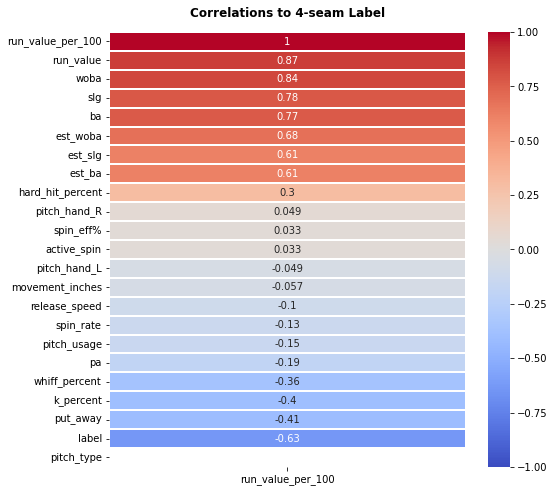

In [7]:
plt.figure(figsize = (8, 8))
sns.heatmap(X_ff.corr()[['run_value_per_100']].sort_values(('run_value_per_100'), ascending = False), 
            annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1, linewidths = 2)
plt.title('Correlations to 4-seam Label', fontweight = 'bold', pad = 15);

Positively correlated with label

Negatively correlated with lablel so the better the negatives the lower the run value / 100

###  Multicolinearity - 4-Seam

In [8]:
vif_data = pd.DataFrame()
vif_data["feature"] = X_ff.columns

vif_data["VIF"] = [variance_inflation_factor(X_ff.values, i)
                   for i in range(len(X_ff.columns))]

vif_data.sort_values(by = 'VIF').head(13)

,feature,VIF
0,pitch_type,0.000000
9,pa,1.311996
1,pitch_usage,1.360626
2,release_speed,1.828199
19,hard_hit_percent,1.909274
22,label,3.185453
3,spin_rate,3.347490
15,put_away,3.675295
13,whiff_percent,4.288891
8,run_value,4.883430


### Logistic Regression - 4-Seam

In [9]:
X = X_ff.drop(columns = ['label'])
y = X_ff['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

lr = LogisticRegression(random_state = 1)
lr.fit(X_train, y_train)

pred_ff = lr.predict(X_test)
pred_probs_ff = lr.predict_proba(X_test)[:,1]

print('Predicted Labels:', pred_ff[:10], '\n')
print('Coeff:', lr.coef_, '\n')
#print('Predicted Probabilites:', pred_probs_ff)

Predicted Labels: [1 1 0 1 1 1 0 1 1 1] 

Coeff: [[-3.21789450e-03  4.16007167e-02 -1.08280866e-01  2.33900432e-03
   4.79438303e-02 -1.01216142e-02 -3.71975608e-05 -1.65349076e-01
  -7.31550114e-01 -2.28842599e-03 -1.12309535e-02 -2.04418303e-02
  -1.20791111e-02  1.43582011e-01  3.82398715e-01  4.57443318e-02
  -7.10060400e-03 -1.32632929e-02 -7.96151359e-03 -1.84907179e-01
  -1.96114824e-02  1.63935879e-02]] 



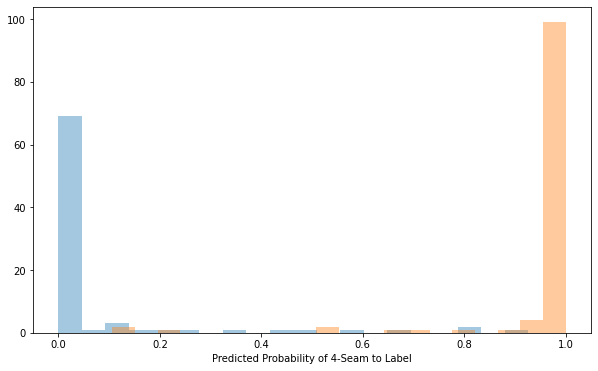

In [10]:
pred_ff_df = pd.DataFrame({'true_values': y_test, 'pred_probs': pred_probs_ff})

plt.figure(figsize = (10, 6))
for group in pred_ff_df.groupby('true_values'):
    sns.distplot(group[1], kde = False, bins = 20)

plt.xlabel('Predicted Probability of 4-Seam to Label');
#plt.legend();

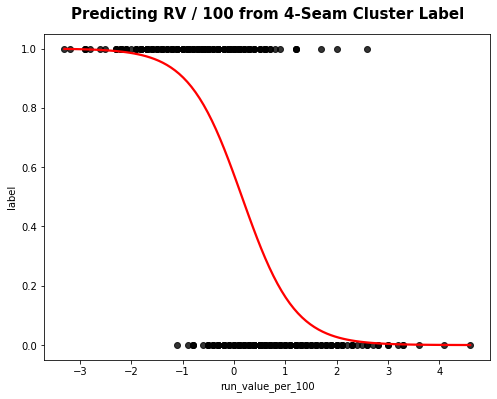

In [11]:
plt.figure(figsize = (8, 6))
sns.regplot(x = X_ff['run_value_per_100'], y = X_ff['label'], data = X_ff, logistic = True, ci = None,
            scatter_kws = {'color': 'black'}, line_kws = {'color': 'red'})
plt.title('Predicting RV / 100 from 4-Seam Cluster Label', fontweight = 'bold', fontsize = 15, pad = 15);

In [12]:
print('Train score:', round(lr.score(X_train, y_train), 2))
print('Test score:', round(lr.score(X_test, y_test), 2)) 
print('Cross val score', round(cross_val_score(lr, X_train, y_train).mean(), 4))

Train score: 0.93
Test score: 0.91
Cross val score 0.9243


## Slider

In [13]:
features_sl = sl.select_dtypes([np.number])
X_sl = features_sl

X_sl_scaled = ss.fit_transform(X_sl)
X_sl_scaled[:,:] *= -1

pca = PCA().fit(X_sl_scaled)
principal_components_sl = pca.transform(X_sl_scaled)

model_sl = pd.DataFrame(data = principal_components_sl, columns = X_sl.columns)

print(model_sl.shape)
model_sl.head()

(256, 22)


,pitch_type,pitch_usage,release_speed,spin_rate,movement_inches,spin_eff%,active_spin,run_value_per_100,run_value,pa,ba,slg,woba,whiff_percent,k_percent,put_away,est_ba,est_slg,est_woba,hard_hit_percent,pitch_hand_L,pitch_hand_R
0,2.897880,-0.905036,-1.162522,-0.012974,1.693329,-0.308969,-0.714245,0.882465,0.544925,0.654722,-0.337647,-0.033740,-0.086116,0.257767,0.137602,-0.090975,0.309115,-0.177238,-0.108266,-0.015331,1.110223e-16,0.0
1,-2.364754,0.253613,-1.763559,3.800426,0.674194,2.641785,0.388628,-0.095079,0.596987,0.483579,-0.977486,-0.520154,-0.575670,0.223875,0.912380,0.519003,0.106438,0.069984,-0.065123,-0.001322,-2.775558e-16,0.0
2,7.387784,-0.324116,2.244467,-0.263817,0.345425,-0.306177,0.017979,-0.317455,0.667936,0.690109,0.521707,0.085594,0.272430,0.363302,-0.105985,0.160388,0.062703,-0.234557,-0.087017,0.002810,-2.220446e-16,0.0
3,-1.432226,-1.469772,-1.326576,0.421007,-1.119323,0.305264,-0.769231,0.889114,0.746178,-0.282303,0.271077,-0.301756,-0.481035,-0.137471,-0.152743,-0.059868,0.061735,0.019183,-0.055393,0.009759,2.775558e-16,0.0
4,-0.247405,-2.939896,-1.468176,0.478129,-0.209946,-0.946171,0.383900,-1.189379,0.354489,0.598710,0.139337,-0.191516,-0.382607,0.134597,0.534754,-0.459448,-0.083467,-0.009192,0.053495,-0.017027,-5.551115e-17,0.0


In [14]:
km_sl = KMeans(n_clusters = 2, 
               random_state = 1)

km_sl.fit(model_sl)
label_sl = km_sl.fit_predict(model_sl)

print('Number of iterations:', km_sl.n_iter_)
print('Number of features:', km_sl.n_features_in_)
print('Number of clusters:', km_sl.n_clusters)
print('Inertia:', km_sl.inertia_, '\n')
print("Predicted clusters to points: ", label_sl[:10], '\n')
#centroids_sl = km_sl.cluster_centers_
#print('Location of centroids:', '\n')
#print(centroids_sl)

Number of iterations: 8
Number of features: 22
Number of clusters: 2
Inertia: 3997.1463372894314 

Predicted clusters to points:  [1 0 1 0 0 1 1 0 1 1] 



### Cluster Labels - Slider

In [15]:
# 0: good
# 1: bad

X_sl['label'] = label_sl
model_sl['label'] = label_sl
#model_sl.groupby(by = 'label').mean().T
X_sl.groupby(by = 'label').mean().T

label,0,1
pitch_type,2.000000,2.000000
pitch_usage,35.265625,28.982031
release_speed,84.846094,84.442969
spin_rate,2476.359375,2370.906250
movement_inches,9.587500,7.346875
spin_eff%,38.898438,34.218750
active_spin,0.389190,0.342528
run_value_per_100,-1.462500,0.589063
run_value,-5.851562,1.757812
pa,109.742188,104.945312


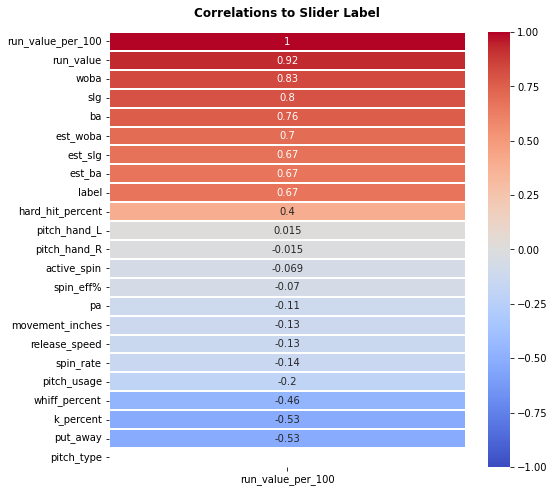

In [16]:
plt.figure(figsize = (8, 8))
sns.heatmap(X_sl.corr()[['run_value_per_100']].sort_values(('run_value_per_100'), ascending = False), 
            annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1, linewidths = 2)
plt.title('Correlations to Slider Label', fontweight = 'bold', pad = 15);

### Multicolinearity - Slider

In [17]:
vif_data = pd.DataFrame()
vif_data["feature"] = X_sl.columns

vif_data["VIF"] = [variance_inflation_factor(X_sl.values, i)
                   for i in range(len(X_sl.columns))]

vif_data.sort_values(by = 'VIF').head(12)

,feature,VIF
0,pitch_type,0.000000
1,pitch_usage,1.289818
3,spin_rate,1.514208
9,pa,1.594778
19,hard_hit_percent,2.347692
2,release_speed,2.445856
22,label,3.089402
13,whiff_percent,4.173957
15,put_away,4.711104
4,movement_inches,6.842503


### Logistic Regression - Slider

In [18]:
X = X_sl.drop(columns = ['label'])
y = X_sl['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

lr = LogisticRegression(random_state = 1)
lr.fit(X_train, y_train)

pred_sl = lr.predict(X_test)
pred_probs_sl = lr.predict_proba(X_test)[:,1]

print('Predicted Labels:', pred_sl[:10], '\n')
print('Coeff:', lr.coef_, '\n')
#print('Predicted Probabilites:', pred_probs_sl)

Predicted Labels: [1 0 1 1 1 0 0 1 1 1] 

Coeff: [[ 5.76020190e-03 -1.20650731e-02  5.64432054e-02  2.40303094e-04
  -1.58770894e-02 -2.41218323e-02 -1.32878142e-04  1.57810071e-01
   5.60680802e-01  2.02373005e-02  8.14046733e-03  1.70120697e-02
   1.03994522e-02 -4.24746480e-02 -2.64525798e-01 -5.67993652e-02
   5.54329902e-03  1.28014561e-02  7.67396565e-03  2.05978368e-01
   1.66890399e-03  1.21119696e-03]] 



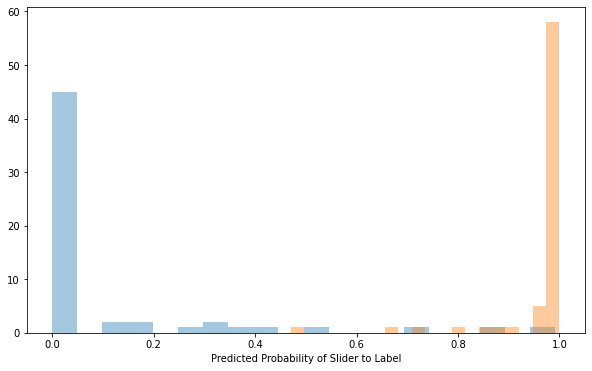

In [19]:
pred_sl_df = pd.DataFrame({'true_values': y_test, 'pred_probs': pred_probs_sl})

plt.figure(figsize = (10, 6))
for group in pred_sl_df.groupby('true_values'):
    sns.distplot(group[1], kde = False, bins = 20)

plt.xlabel('Predicted Probability of Slider to Label');
#plt.legend();

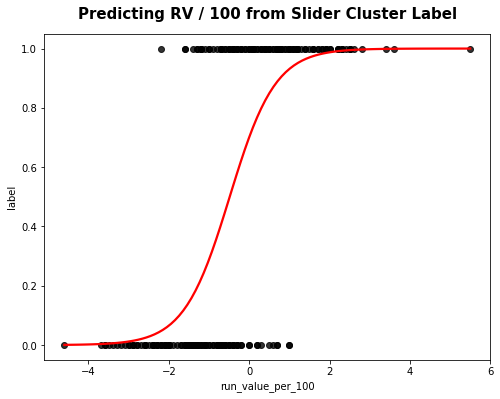

In [20]:
plt.figure(figsize = (8, 6))
sns.regplot(x = X_sl['run_value_per_100'], y = X_sl['label'], data = X_sl, logistic = True, ci = None,
            scatter_kws = {'color': 'black'}, line_kws = {'color': 'red'})
plt.title('Predicting RV / 100 from Slider Cluster Label', fontweight = 'bold', fontsize = 15, pad = 15);

In [21]:
print('Train score:', round(lr.score(X_train, y_train), 2))
print('Test score:', round(lr.score(X_test, y_test), 2)) 
print('Cross val score', round(cross_val_score(lr, X_train, y_train).mean(), 4))

Train score: 0.93
Test score: 0.92
Cross val score 0.9113


## Changeup

In [22]:
features_ch = ch.select_dtypes([np.number])
X_ch = features_ch

X_ch_scaled = ss.fit_transform(X_ch)
X_ch_scaled[:,:] *= -1

pca = PCA().fit(X_ch_scaled)
principal_components_ch = pca.transform(X_ch_scaled)

model_ch = pd.DataFrame(data = principal_components_ch, columns = X_ch.columns)

print(model_ch.shape)
model_ch.head()

(124, 22)


,pitch_type,pitch_usage,release_speed,spin_rate,movement_inches,spin_eff%,active_spin,run_value_per_100,run_value,pa,ba,slg,woba,whiff_percent,k_percent,put_away,est_ba,est_slg,est_woba,hard_hit_percent,pitch_hand_L,pitch_hand_R
0,3.630092,-0.960619,1.211631,-1.825185,0.272343,-0.614653,0.974013,-0.379783,0.231763,-0.270343,0.634386,-0.116954,-0.254386,-0.220415,-0.637458,-0.276082,0.006103,0.494334,-0.054042,-0.021149,1.110223e-16,0.0
1,-1.233524,0.885768,1.094864,0.563629,-0.622975,0.179881,-2.451840,-1.014923,-1.949612,-0.541824,-0.177268,0.234600,0.142744,0.160670,-0.139632,-0.009490,-0.064430,-0.046794,-0.004031,0.007254,2.220446e-16,0.0
2,1.716014,-0.526086,-0.719893,-1.074310,1.622720,-0.301405,-0.527981,0.194281,0.340495,-0.021799,1.080243,-0.395101,0.506205,0.384601,0.134626,-0.238632,-0.246229,-0.034387,0.069995,-0.004260,1.110223e-16,0.0
3,2.975249,-1.875122,-0.516173,-0.373241,0.471403,-0.331950,0.369035,0.030365,0.277092,0.098084,-0.333759,-0.242808,0.338815,-0.030857,0.014730,-0.174857,0.093764,0.101091,-0.205306,0.005213,2.220446e-16,0.0
4,1.794250,-2.071385,-0.139755,-1.406802,-0.731856,0.563248,0.724598,-0.281740,0.023869,-0.143416,0.193719,0.405459,-0.664839,-0.070122,0.433141,0.420391,0.044449,-0.068325,0.012840,-0.015922,3.330669e-16,0.0


In [23]:
km_ch = KMeans(n_clusters = 2, 
               random_state = 1)

km_ch.fit(model_ch)
label_ch = km_ch.fit_predict(model_ch)

print('Number of iterations:', km_ch.n_iter_)
print('Number of features:', km_ch.n_features_in_)
print('Number of clusters:', km_ch.n_clusters)
print('Inertia:', km_ch.inertia_, '\n')
print("Predicted clusters to points: ", label_ch[:10], '\n')
#centroids_ch = km_ch.cluster_centers_
#print('Location of centroids:', '\n')
#print(centroids_ch)

Number of iterations: 3
Number of features: 22
Number of clusters: 2
Inertia: 1992.513376580886 

Predicted clusters to points:  [1 0 1 1 1 0 0 0 1 0] 



### Cluster Labels - Changeup

In [24]:
# 0: good
# 1: bad

X_ch['label'] = label_ch
model_ch['label'] = label_ch
#model_ch.groupby(by = 'label').mean().T
X_ch.groupby(by = 'label').mean().T

label,0,1
pitch_type,3.000000,3.000000
pitch_usage,27.473770,20.987302
release_speed,85.098361,84.225397
spin_rate,1803.524590,1704.476190
movement_inches,16.691803,15.800000
spin_eff%,90.836066,89.492063
active_spin,0.909538,0.895655
run_value_per_100,-1.052459,0.963492
run_value,-4.295082,3.444444
pa,119.688525,110.777778


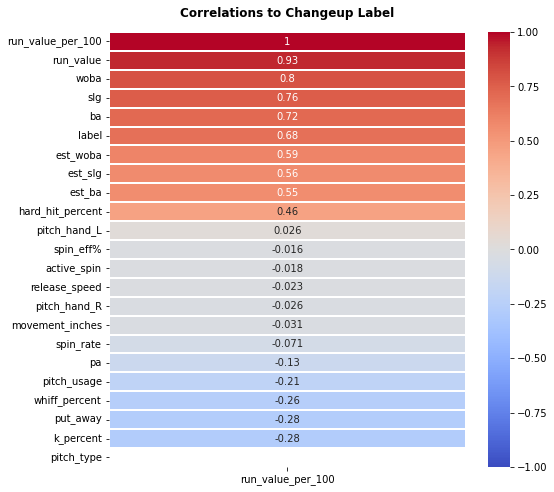

In [25]:
plt.figure(figsize = (8, 8))
sns.heatmap(X_ch.corr()[['run_value_per_100']].sort_values(('run_value_per_100'), ascending = False), 
            annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1, linewidths = 2)
plt.title('Correlations to Changeup Label', fontweight = 'bold', pad = 15);

### Multicolinearity - Changeup

In [26]:
vif_data = pd.DataFrame()
vif_data["feature"] = X_ch.columns

vif_data["VIF"] = [variance_inflation_factor(X_ch.values, i)
                   for i in range(len(X_ch.columns))]

vif_data.sort_values(by = 'VIF').head(11)

,feature,VIF
0,pitch_type,0.000000
9,pa,1.340883
2,release_speed,1.566007
1,pitch_usage,1.682970
19,hard_hit_percent,2.647209
22,label,3.664963
3,spin_rate,3.729975
13,whiff_percent,3.776188
15,put_away,4.035128
4,movement_inches,6.326863


### Logistic Regression - Changeup

In [27]:
X = X_ch.drop(columns = ['label'])
y = X_ch['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

lr = LogisticRegression(random_state = 1)
lr.fit(X_train, y_train)

pred_ch = lr.predict(X_test)
pred_probs_ch = lr.predict_proba(X_test)[:,1]

print('Predicted Labels:', pred_ch[:10], '\n')
print('Coeff:', lr.coef_, '\n')
#print('Predicted Probabilites:', pred_probs_ch)

Predicted Labels: [1 0 0 1 0 1 0 1 0 1] 

Coeff: [[ 3.61568619e-02 -1.98190755e-01  1.93213340e-01  7.57240310e-04
  -2.04315862e-01 -1.36977917e-01 -1.25935904e-03  3.13641971e-01
   1.20097849e+00  1.11858041e-02  1.11637474e-02  3.04902683e-02
   1.85451103e-02 -1.57969319e-01 -2.77360504e-01  3.91603708e-02
   1.52813496e-02  3.80054104e-02  2.24749137e-02  3.97745536e-01
   7.20572569e-03  4.84656161e-03]] 



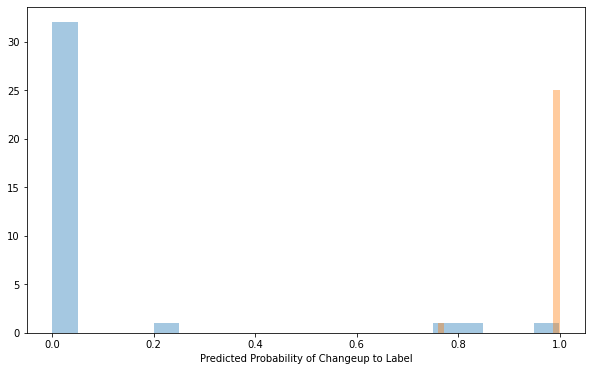

In [28]:
pred_ch_df = pd.DataFrame({'true_values': y_test, 'pred_probs': pred_probs_ch})

plt.figure(figsize = (10, 6))
for group in pred_ch_df.groupby('true_values'):
    sns.distplot(group[1], kde = False, bins = 20)

plt.xlabel('Predicted Probability of Changeup to Label');
#plt.legend();

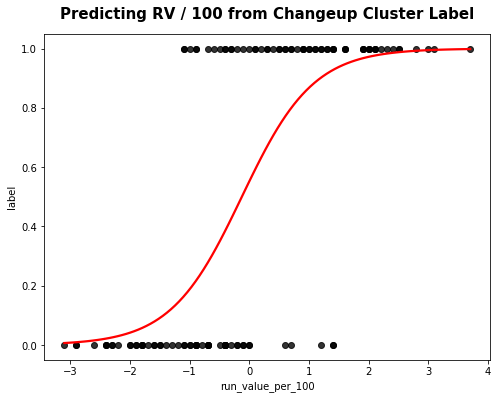

In [29]:
plt.figure(figsize = (8, 6))
sns.regplot(x = X_ch['run_value_per_100'], y = X_ch['label'], data = X_ch, logistic = True, ci = None,
            scatter_kws = {'color': 'black'}, line_kws = {'color': 'red'})
plt.title('Predicting RV / 100 from Changeup Cluster Label', fontweight = 'bold', fontsize = 15, pad = 15);

In [30]:
print('Train score:', round(lr.score(X_train, y_train), 2))
print('Test score:', round(lr.score(X_test, y_test), 2)) 
print('Cross val score', round(cross_val_score(lr, X_train, y_train).mean(), 4))

Train score: 0.96
Test score: 0.9
Cross val score 0.8813


## Cutter

In [31]:
features_fc = fc.select_dtypes([np.number])
X_fc = features_fc

X_fc_scaled = ss.fit_transform(X_fc)
X_fc_scaled[:,:] *= -1

pca = PCA().fit(X_fc_scaled)
principal_components_fc = pca.transform(X_fc_scaled)
model_fc = pd.DataFrame(data = principal_components_fc, columns = X_fc.columns)

print(model_fc.shape)
model_fc.head()

(80, 22)


,pitch_type,pitch_usage,release_speed,spin_rate,movement_inches,spin_eff%,active_spin,run_value_per_100,run_value,pa,ba,slg,woba,whiff_percent,k_percent,put_away,est_ba,est_slg,est_woba,hard_hit_percent,pitch_hand_L,pitch_hand_R
0,0.333615,-0.364379,2.176455,-0.856558,0.527774,0.949225,-0.070907,0.038031,-0.080983,0.297267,-0.499071,0.131166,-0.142509,-0.220252,0.135124,0.158771,-0.019312,-0.118430,0.028663,0.010590,-2.220446e-16,0.0
1,-3.727422,-1.556018,1.220279,0.111888,0.312337,-0.172849,0.149275,0.038884,-0.076055,-0.585890,-0.130628,0.102653,0.234626,-0.186925,0.034469,-0.487011,-0.088879,0.074985,0.017393,0.005246,0.000000e+00,0.0
2,0.862038,-0.414066,1.976816,-1.401725,0.840583,1.375113,-1.019735,-0.325646,0.405159,0.144936,-0.271451,-0.614541,0.576418,-0.189250,-0.067353,0.095976,-0.100693,-0.104143,0.053892,0.016710,-1.110223e-16,0.0
3,-1.645065,-0.820904,-3.207936,-0.515661,-0.181371,0.244023,0.268599,1.114144,0.125923,-0.179362,0.223255,0.038559,0.483124,-0.291944,0.224869,0.183211,-0.319833,-0.124799,-0.237506,0.006750,2.220446e-16,0.0
4,0.124647,-0.656455,-2.213750,-1.418436,-1.159388,-0.243385,1.469135,-0.013744,0.172889,-0.367992,0.398161,0.042114,0.262332,0.040600,-0.083963,0.444372,-0.193158,-0.290498,-0.012682,0.016575,1.110223e-16,0.0


In [32]:
km_fc = KMeans(n_clusters = 2, 
               random_state = 1)

km_fc.fit(model_fc)
label_fc = km_fc.fit_predict(model_fc)

print('Number of iterations:', km_fc.n_iter_)
print('Number of features:', km_fc.n_features_in_)
print('Number of clusters:', km_fc.n_clusters)
print('Inertia:', km_fc.inertia_, '\n')
print("Predicted clusters to points: ", label_fc[:10], '\n')
#centroids_fc = km_fc.cluster_centers_
#print('Location of centroids:', '\n')
#print(centroids_fc)

Number of iterations: 6
Number of features: 22
Number of clusters: 2
Inertia: 1251.98592372935 

Predicted clusters to points:  [1 0 1 0 1 0 1 1 0 1] 



### Cluster Labels - Cutter

In [33]:
# 0: bad
# 1: good

X_fc['label'] = label_fc
model_fc['label'] = label_fc
#model_fc.groupby(by = 'label').mean().T
X_fc.groupby(by = 'label').mean().T

label,0,1
pitch_type,4.000000,4.000000
pitch_usage,27.987805,35.787179
release_speed,87.965854,88.907692
spin_rate,2291.390244,2447.769231
movement_inches,8.919512,8.100000
spin_eff%,51.682927,42.564103
active_spin,0.517060,0.426159
run_value_per_100,0.748780,-1.041026
run_value,2.951220,-5.000000
pa,125.146341,115.512821


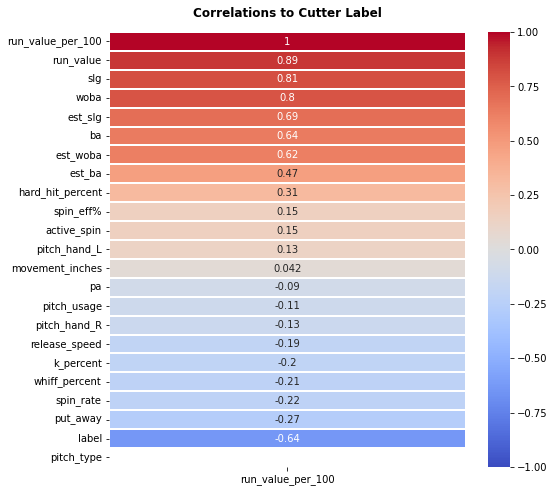

In [34]:
plt.figure(figsize = (8, 8))
sns.heatmap(X_fc.corr()[['run_value_per_100']].sort_values(('run_value_per_100'), ascending = False), 
            annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1, linewidths = 2)
plt.title('Correlations to Cutter Label', fontweight = 'bold', pad = 15);

### Multicolinearity - Cutter

In [35]:
vif_data = pd.DataFrame()
vif_data["feature"] = X_fc.columns

vif_data["VIF"] = [variance_inflation_factor(X_fc.values, i)
                   for i in range(len(X_fc.columns))]

vif_data.sort_values(by = 'VIF').head(11)

,feature,VIF
0,pitch_type,0.000000
1,pitch_usage,1.992751
19,hard_hit_percent,2.046196
9,pa,2.167748
2,release_speed,2.333700
13,whiff_percent,2.977997
3,spin_rate,3.345599
22,label,4.010590
15,put_away,5.254040
14,k_percent,6.955554


### Logistic Regression - Cutter

In [36]:
X = X_fc.drop(columns = ['label'])
y = X_fc['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

lr = LogisticRegression(random_state = 1)
lr.fit(X_train, y_train)

pred_fc = lr.predict(X_test)
pred_probs_fc = lr.predict_proba(X_test)[:,1]

print('Predicted Labels:', pred_fc[:10], '\n')
print('Coeff:', lr.coef_, '\n')
#print('Predicted Probabilites:', pred_probs_fc[:10])

Predicted Labels: [0 1 1 1 0 1 1 0 0 0] 

Coeff: [[-1.83162662e-02  1.67263820e-01 -1.86861007e-01  1.00591979e-02
  -1.49071138e-01  5.29537308e-02  2.06056837e-04 -1.81372607e-01
  -6.81679453e-01 -5.89670004e-02 -1.73544465e-02 -4.40689944e-02
  -2.50603048e-02  3.20242016e-01  9.26272528e-01 -1.42496438e-01
  -2.02771798e-02 -3.65100115e-02 -2.29104643e-02 -8.57663740e-01
  -5.77342114e-02  5.31551449e-02]] 



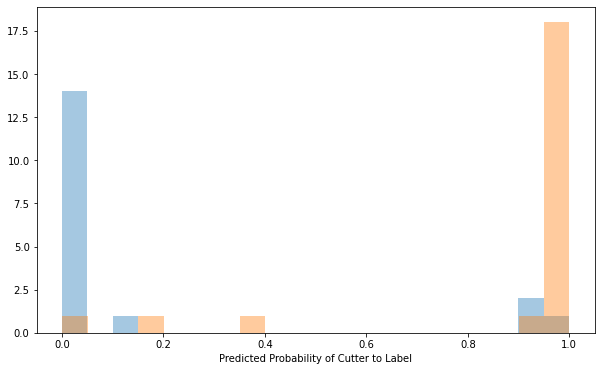

In [37]:
pred_fc_df = pd.DataFrame({'true_values': y_test, 'pred_probs': pred_probs_fc})

plt.figure(figsize = (10, 6))
for group in pred_fc_df.groupby('true_values'):
    sns.distplot(group[1], kde = False, bins = 20)

plt.xlabel('Predicted Probability of Cutter to Label');
#plt.legend();

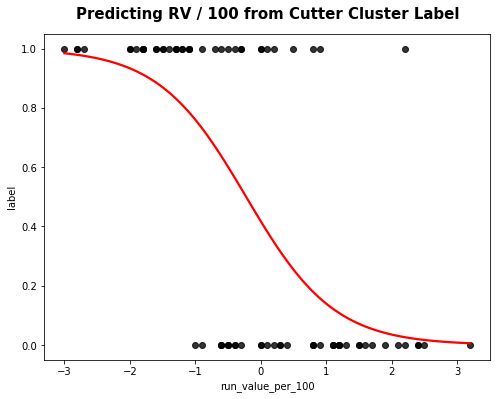

In [38]:
plt.figure(figsize = (8, 6))
sns.regplot(x = X_fc['run_value_per_100'], y = X_fc['label'], data = X_fc, logistic = True, ci = None,
            scatter_kws = {'color': 'black'}, line_kws = {'color': 'red'})
plt.title('Predicting RV / 100 from Cutter Cluster Label', fontweight = 'bold', fontsize = 15, pad = 15);

In [39]:
print('Train score:', round(lr.score(X_train, y_train), 2))
print('Test score:', round(lr.score(X_test, y_test), 2)) 
print('Cross val score', round(cross_val_score(lr, X_train, y_train).mean(), 4))

Train score: 1.0
Test score: 0.7
Cross val score 0.8833
